In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Rice_Image_Dataset.zip'
extract_path = '/content/rice_dataset'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Count total images and distribution per class

import os

data_dir = '/content/rice_dataset/Rice_Image_Dataset'

# Get list of class folders
classes = os.listdir(data_dir)
print(f"Found {len(classes)} classes: {classes}\n")

# Count images per class
total_images = 0
class_counts = {}

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    img_count = len(os.listdir(cls_path))
    class_counts[cls] = img_count
    total_images += img_count

print("Image count per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

print(f"\nTotal images: {total_images}")


Found 5 classes: ['Ipsala', 'Basmati', 'Karacadag', 'Jasmine', 'Arborio']

Image count per class:
Ipsala: 15000 images
Basmati: 15000 images
Karacadag: 15000 images
Jasmine: 15000 images
Arborio: 15000 images

Total images: 75000


In [6]:
# check for corrupt images
from PIL import Image
import os

data_dir = '/content/rice_dataset/Rice_Image_Dataset'
corrupt_images = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception as e:
            corrupt_images.append(img_path)

print(f"Total corrupt images found: {len(corrupt_images)}")


Total corrupt images found: 0


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/content/rice_dataset/Rice_Image_Dataset'

img_height, img_width = 224, 224
batch_size = 32

# Create ImageDataGenerators
datagen = ImageDataGenerator(
    rescale=1./255,       # normalization
    validation_split=0.2  # 80% train, 20% validation
)

# Train generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


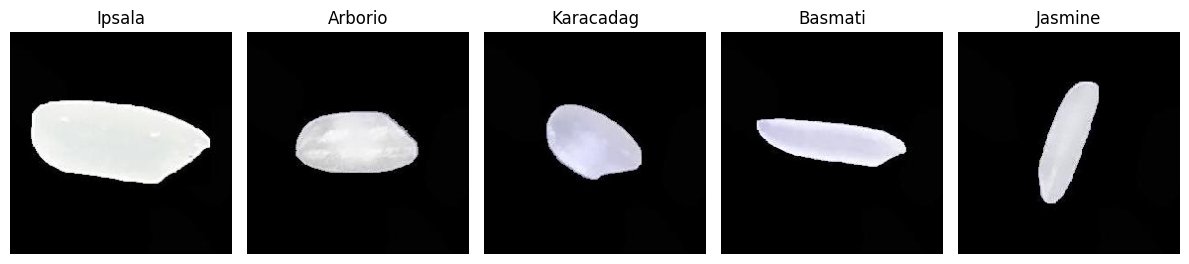

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get class indices mapping
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Grab one batch from the generator
images, labels = next(train_generator)

# Plot one image per class
shown_classes = set()
plt.figure(figsize=(12, 6))

for i in range(len(images)):
    label_idx = np.argmax(labels[i])
    class_name = idx_to_class[label_idx]

    if class_name not in shown_classes:
        shown_classes.add(class_name)
        plt.subplot(1, len(class_indices), len(shown_classes))
        plt.imshow(images[i])
        plt.title(class_name)
        plt.axis('off')

    if len(shown_classes) == len(class_indices):
        break

plt.tight_layout()
plt.show()


In [9]:
# Basic model building
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(train_generator.class_indices)

model = models.Sequential([
    # Conv Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,461 (42.65 MB)

 Trainable params: 11,179,461 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator
)

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 62ms/step - accuracy: 0.9286 - loss: 0.1940 - val_accuracy: 0.9700 - val_loss: 0.0859
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 111s 59ms/step - accuracy: 0.9712 - loss: 0.0849 - val_accuracy: 0.9721 - val_loss: 0.0812
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.9770 - loss: 0.0684 - val_accuracy: 0.9781 - val_loss: 0.0636
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 113s 60ms/step - accuracy: 0.9833 - loss: 0.0489 - val_accuracy: 0.9837 - val_loss: 0.0468


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step


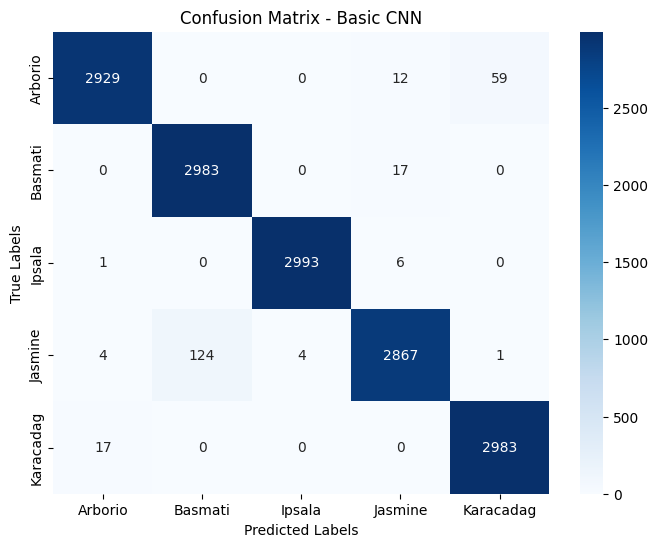

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation data
val_preds_basic = model.predict(val_generator)
val_preds_classes_basic = np.argmax(val_preds_basic, axis=1)
val_true_classes_basic = val_generator.classes

# Confusion matrix
cm_basic = confusion_matrix(val_true_classes_basic, val_preds_classes_basic)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Basic CNN')
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step
Precision: 0.9839
Recall: 0.9837
F1 Score: 0.9836


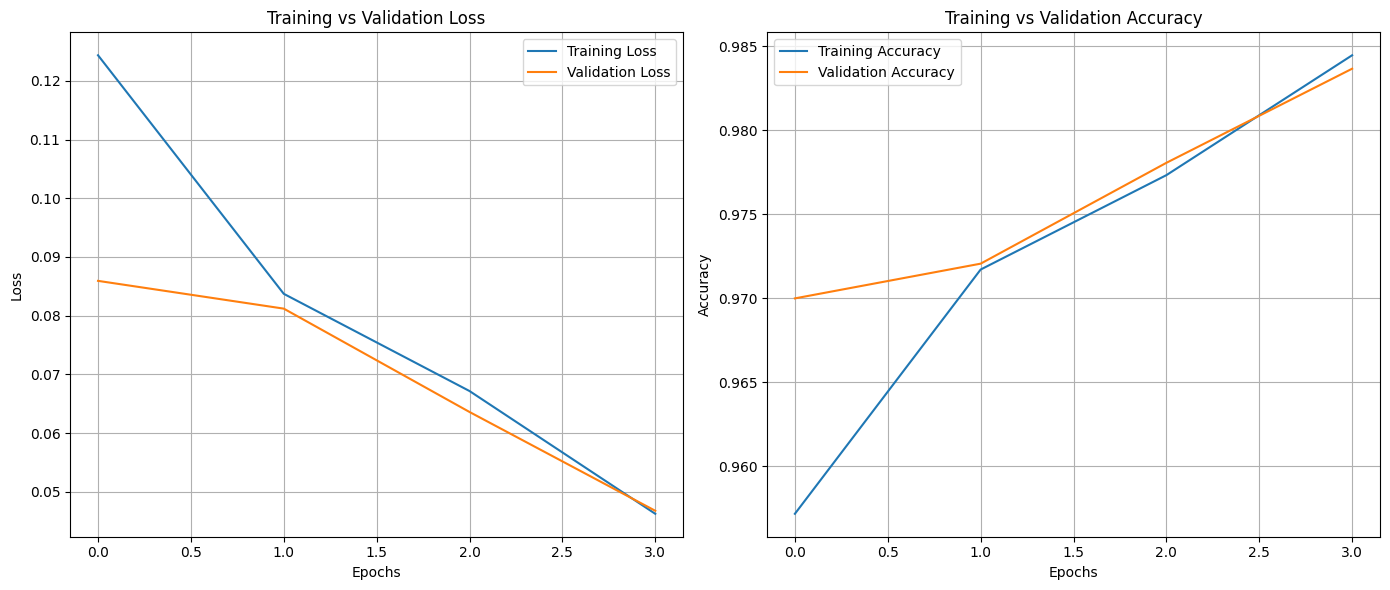

In [11]:
# Model evaluation

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


val_preds = model.predict(val_generator, verbose=1)
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = val_generator.classes

# Calculate precision, recall, and F1-score
precision = precision_score(val_true_classes, val_preds_classes, average='weighted')
recall = recall_score(val_true_classes, val_preds_classes, average='weighted')
f1 = f1_score(val_true_classes, val_preds_classes, average='weighted')

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [12]:
# deeper model with double layers
import time
from tensorflow.keras import layers, models

start_time = time.time()

deeper_model = models.Sequential([
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Fully connected layers
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile
deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Summary
deeper_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,203,109 (73.25 MB)

 Trainable params: 19,203,109 (73.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 260s 130ms/step - accuracy: 0.9249 - loss: 0.2163 - val_accuracy: 0.9726 - val_loss: 0.0864
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 235s 125ms/step - accuracy: 0.9705 - loss: 0.0910 - val_accuracy: 0.9671 - val_loss: 0.0963
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 234s 125ms/step - accuracy: 0.9770 - loss: 0.0667 - val_accuracy: 0.9858 - val_loss: 0.0510
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 233s 124ms/step - accuracy: 0.9884 - loss: 0.0366 - val_accuracy: 0.9910 - val_loss: 0.0270

Training Time: 961.97 seconds
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step
Precision: 0.9911
Recall: 0.9910
F1 Score: 0.9910


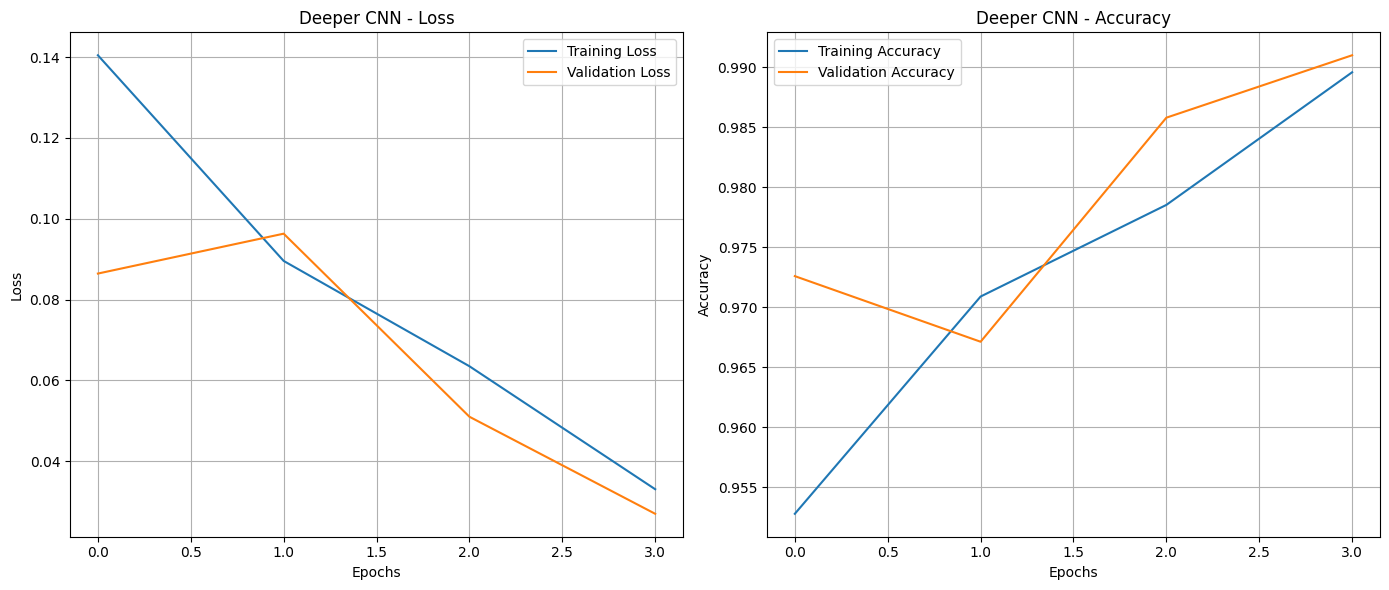

In [13]:
#train the deeper model and evaluate the model with double layers
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import time

start_time = time.time()

# Train model
deep_history = deeper_model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator
)

training_time = time.time() - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")

# Predictions for evaluation
val_preds_deep = deeper_model.predict(val_generator)
val_preds_classes_deep = np.argmax(val_preds_deep, axis=1)
val_true_classes = val_generator.classes

# Evaluation metrics
precision_deep = precision_score(val_true_classes, val_preds_classes_deep, average='weighted')
recall_deep = recall_score(val_true_classes, val_preds_classes_deep, average='weighted')
f1_deep = f1_score(val_true_classes, val_preds_classes_deep, average='weighted')

print(f"Precision: {precision_deep:.4f}")
print(f"Recall: {recall_deep:.4f}")
print(f"F1 Score: {f1_deep:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
axes[0].plot(deep_history.history['loss'], label='Training Loss')
axes[0].plot(deep_history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Deeper CNN - Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(deep_history.history['accuracy'], label='Training Accuracy')
axes[1].plot(deep_history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Deeper CNN - Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


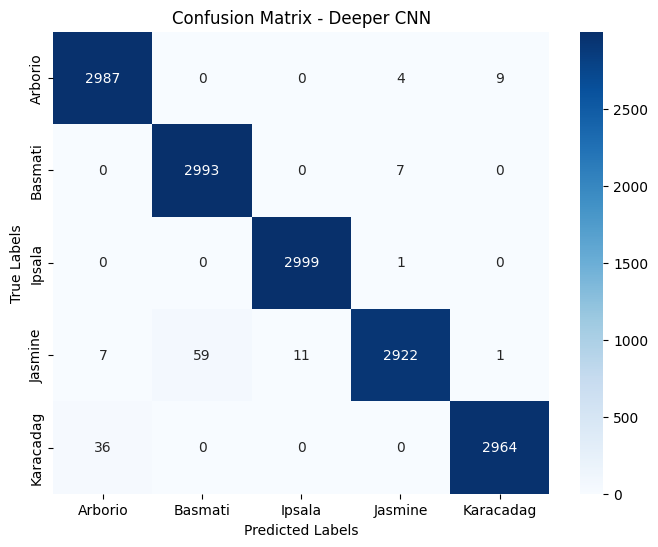

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix
cm = confusion_matrix(val_true_classes, val_preds_classes_deep)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Deeper CNN')
plt.show()

In [14]:
import shutil
shutil.rmtree('/content/rice_dataset/Rice_Image_Dataset/.ipynb_checkpoints', ignore_errors=True)


In [15]:
# data augmentation
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training set
train_aug = augmented_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation set
val_aug = augmented_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


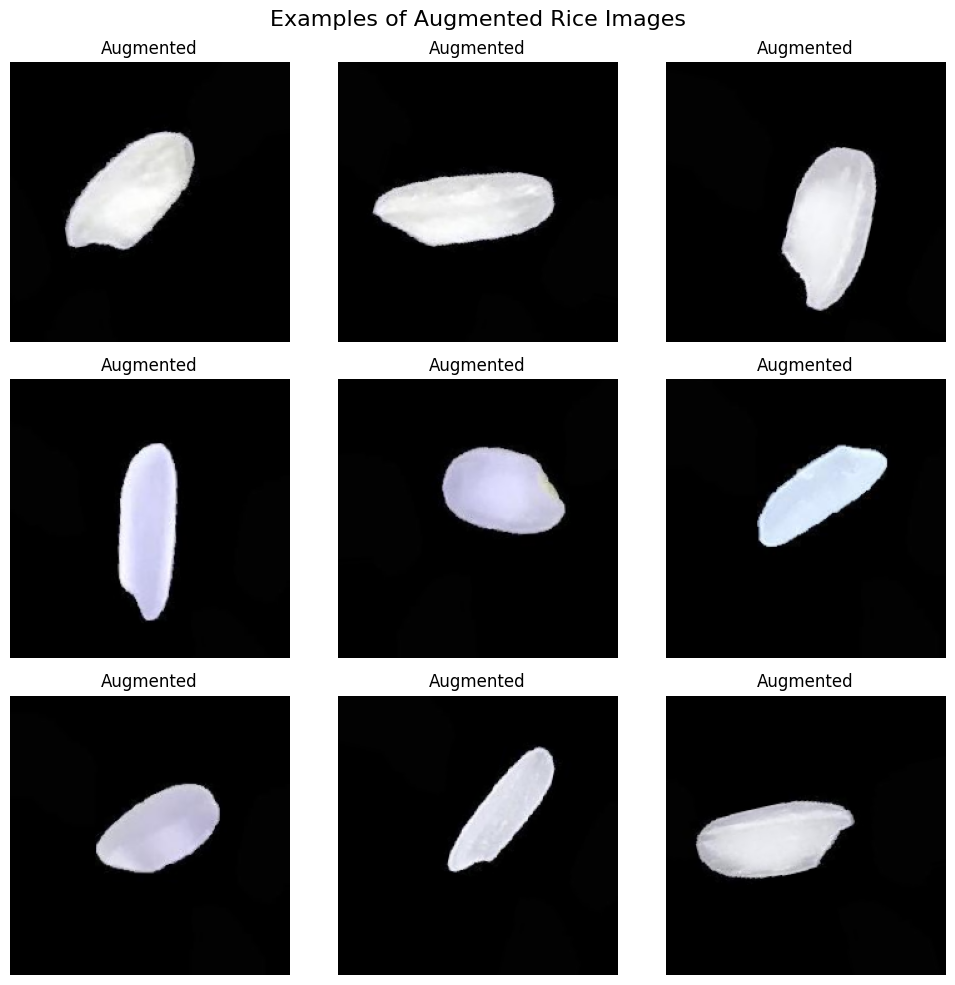

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
augmented_images, _ = next(train_aug)

# 9 example augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title("Augmented")
plt.suptitle("Examples of Augmented Rice Images", fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
# Rebuild deeper model with BN, Dropout, early stopping and model checkpoint (adam optimizer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# Number of classes
num_classes = train_aug.num_classes

reg_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
reg_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_regularized_model.h5', monitor='val_loss', save_best_only=True)

# Train model
start_time = time.time()
reg_history = reg_model.fit(
    train_aug,
    epochs=4,
    validation_data=val_aug,
    callbacks=[early_stop, checkpoint]
)
print(f"\nTraining Time: {time.time() - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6613 - loss: 1.1504

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 967s 510ms/step - accuracy: 0.6614 - loss: 1.1501 - val_accuracy: 0.6912 - val_loss: 1.5223
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 956s 499ms/step - accuracy: 0.9245 - loss: 0.2506 - val_accuracy: 0.2548 - val_loss: 22.4206
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9545 - loss: 0.1571

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 955s 509ms/step - accuracy: 0.9545 - loss: 0.1570 - val_accuracy: 0.7471 - val_loss: 0.7456
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 947s 505ms/step - accuracy: 0.9677 - loss: 0.1125 - val_accuracy: 0.2000 - val_loss: 191.9257

Training Time: 3860.20 seconds


In [18]:
print(val_aug.class_indices)
print(f"Number of classes detected: {len(val_aug.class_indices)}")

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Number of classes detected: 5


In [19]:
class_labels = list(val_aug.class_indices.keys())
print(f"Class labels: {class_labels}")


Class labels: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 391ms/step
Accuracy:  0.7470
Precision: 0.8794
Recall:    0.7470
F1 Score:  0.7136

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.45      1.00      0.62      3000
     Basmati       0.98      0.99      0.99      3000
      Ipsala       0.98      1.00      0.99      3000
     Jasmine       0.99      0.11      0.19      3000
   Karacadag       1.00      0.64      0.78      3000

    accuracy                           0.75     15000
   macro avg       0.88      0.75      0.71     15000
weighted avg       0.88      0.75      0.71     15000



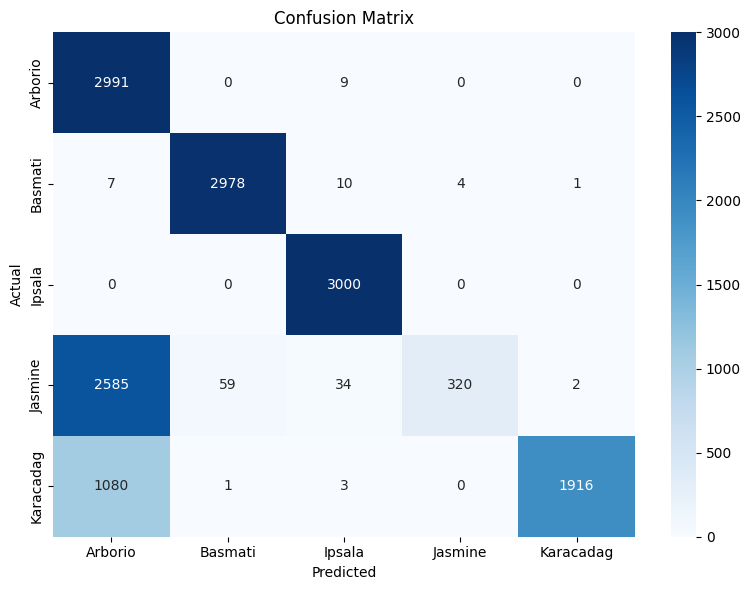

In [20]:
#Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities and convert to class labels
reg_preds = reg_model.predict(val_aug)
reg_preds_classes = np.argmax(reg_preds, axis=1)
val_true_classes = val_aug.classes
class_labels = list(val_aug.class_indices.keys())

# Evaluation metrics
precision = precision_score(val_true_classes, reg_preds_classes, average='weighted')
recall = recall_score(val_true_classes, reg_preds_classes, average='weighted')
f1 = f1_score(val_true_classes, reg_preds_classes, average='weighted')
accuracy = np.mean(val_true_classes == reg_preds_classes)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_classes, reg_preds_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, reg_preds_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


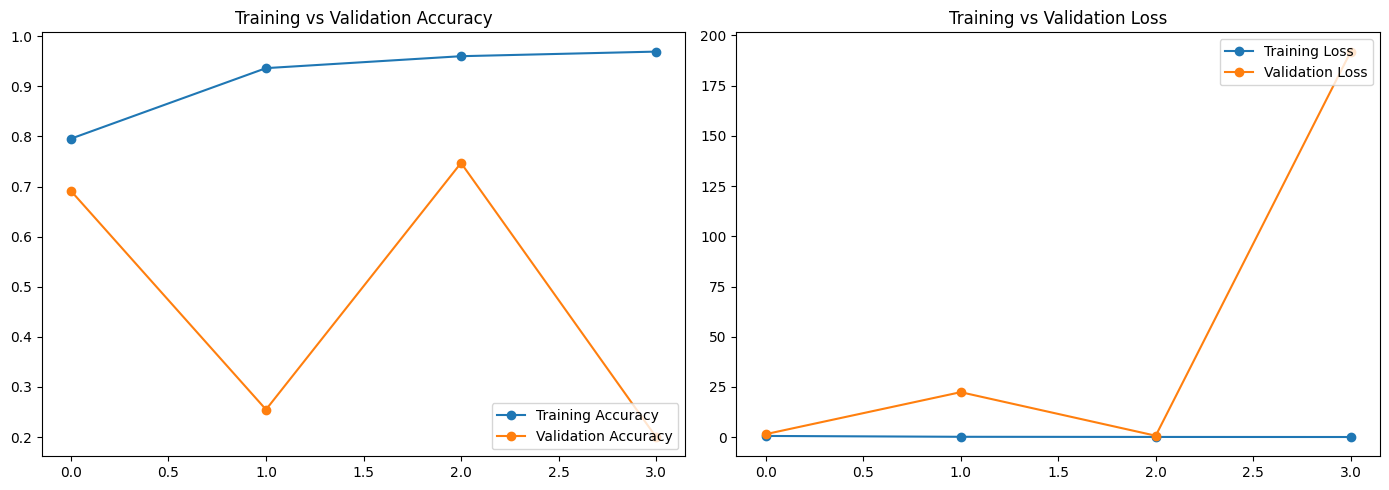

In [21]:
#Model accuracy and loss curve
import matplotlib.pyplot as plt

acc = reg_history.history['accuracy']
val_acc = reg_history.history['val_accuracy']
loss = reg_history.history['loss']
val_loss = reg_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()


In [22]:
#Deeper model with SGD optimizer
from tensorflow.keras.optimizers import SGD

sgd_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile with SGD optimizer
sgd_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop_sgd = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_sgd = ModelCheckpoint('best_sgd_model.h5', monitor='val_loss', save_best_only=True)

# Train with SGD
start_time = time.time()
sgd_history = sgd_model.fit(
    train_aug,
    epochs=4,
    validation_data=val_aug,
    callbacks=[early_stop_sgd, checkpoint_sgd]
)
print(f"\nTraining Time (SGD): {time.time() - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6049 - loss: 1.0405

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 958s 507ms/step - accuracy: 0.6049 - loss: 1.0404 - val_accuracy: 0.2191 - val_loss: 12.0787
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8687 - loss: 0.3859

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 980s 508ms/step - accuracy: 0.8687 - loss: 0.3859 - val_accuracy: 0.4725 - val_loss: 2.6052
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 971s 502ms/step - accuracy: 0.9107 - loss: 0.2678 - val_accuracy: 0.5530 - val_loss: 4.5619
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 969s 517ms/step - accuracy: 0.9396 - loss: 0.1877 - val_accuracy: 0.3719 - val_loss: 24.5531

Training Time (SGD): 3878.24 seconds


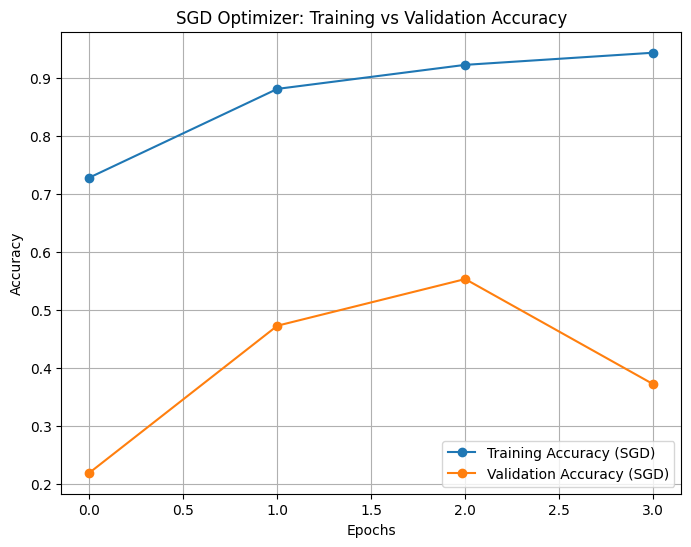

In [23]:
#Accuracy graph for SGD model
acc_sgd = sgd_history.history['accuracy']
val_acc_sgd = sgd_history.history['val_accuracy']
epochs_range = range(len(acc_sgd))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc_sgd, label='Training Accuracy (SGD)', marker='o')
plt.plot(epochs_range, val_acc_sgd, label='Validation Accuracy (SGD)', marker='o')
plt.legend(loc='lower right')
plt.title('SGD Optimizer: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 430ms/step


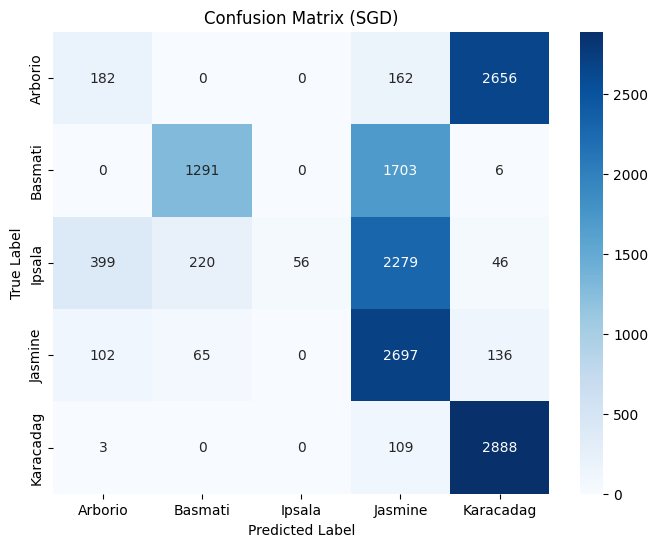

In [24]:
# Confusion Matrix for SGD
val_predictions_sgd = sgd_model.predict(val_aug)

val_true_classes = val_aug.classes
predicted_classes_sgd = np.argmax(val_predictions_sgd, axis=1)

cm_sgd = confusion_matrix(val_true_classes, predicted_classes_sgd)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sgd, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (SGD)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
#Load VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
vgg_model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [28]:
#pretrained model training
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
vgg_history = vgg_model.fit(
    train_aug,
    epochs=4,
    validation_data=val_aug,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7506 - loss: 0.6384

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1102s 581ms/step - accuracy: 0.7507 - loss: 0.6383 - val_accuracy: 0.9603 - val_loss: 0.1044
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9572 - loss: 0.1243

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1019s 544ms/step - accuracy: 0.9572 - loss: 0.1242 - val_accuracy: 0.9685 - val_loss: 0.0910
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9673 - loss: 0.0976

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 992s 529ms/step - accuracy: 0.9673 - loss: 0.0976 - val_accuracy: 0.9806 - val_loss: 0.0549
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9708 - loss: 0.0847

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1002s 534ms/step - accuracy: 0.9708 - loss: 0.0847 - val_accuracy: 0.9847 - val_loss: 0.0420


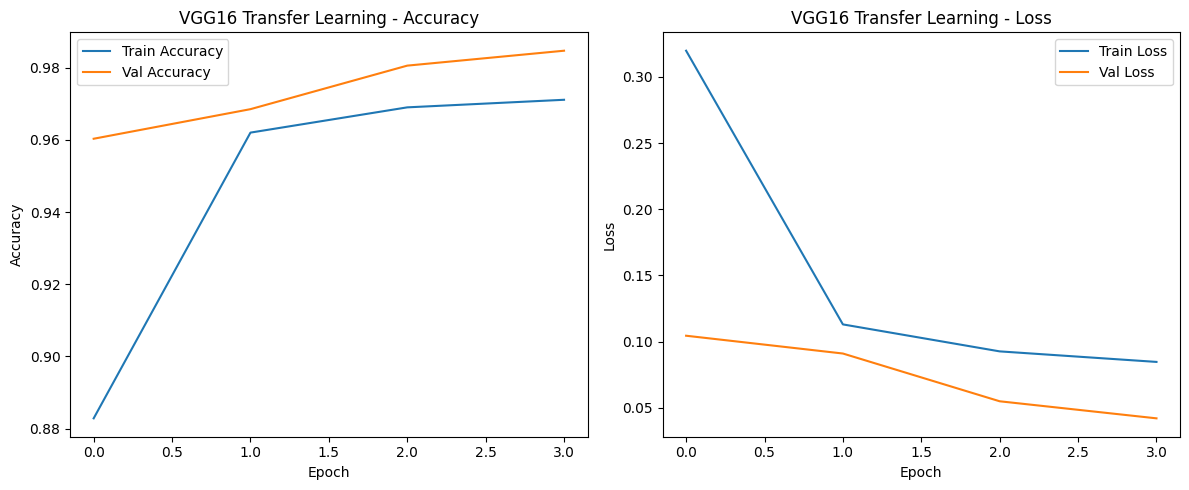

In [29]:
#Accuracy plot for pretrained model

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('VGG16 Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 211s 447ms/step


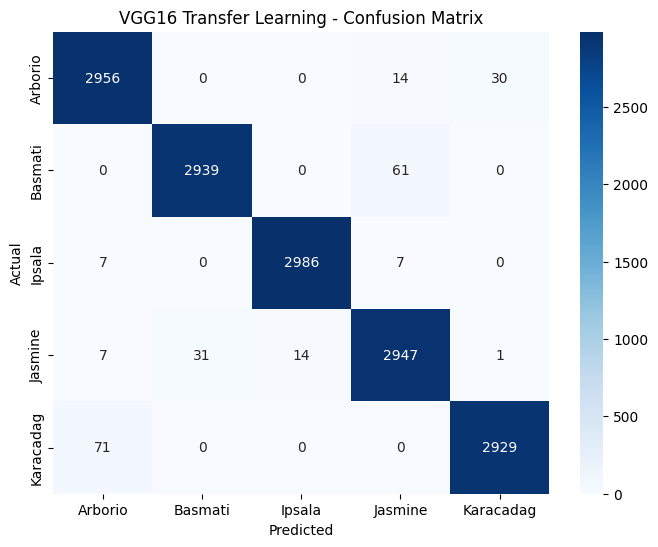

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.97      0.99      0.98      3000
     Basmati       0.99      0.98      0.98      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.97      0.98      0.98      3000
   Karacadag       0.99      0.98      0.98      3000

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

vgg_preds = vgg_model.predict(val_aug)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
val_true_classes = val_aug.classes

class_labels = list(val_aug.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(val_true_classes, vgg_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Transfer Learning - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_true_classes, vgg_pred_classes, target_names=class_labels))
